# Visualizing Fire Scars Through False Color
**Author: Melannie Moreno Rolón**

You can access the link to the GitHub Repository for this project [here](https://github.com/mmorenorolon/eds220-hwk4.git).

### Purpose:
This notebook aims to visualize the fire scars from the Palisades and Eaton fires that ravaged Los Angeles in January of 2025. In this notebook, we use false color imagery as a tool to monitor wildfire impacts of this event. For this notebook, we will be assigning infrared bands to visible colors to highlight vegetation health, burn scars, and the extent of these burn scars. In conclusion, the end-goal of this notebook is to leverage data science tools to determine to support environmental monitoring efforts.

### Highlights: (3 to 4)
- Data Exploration


### About the Data: Datasets Description
- #### Landsat Data:
This dataset is in netcdf format. The data was sourced from the Landsat 8 Collection 2 Level-2. 

Link source:
Source date:
Date Accessed: 11/19/2025
- #### Fire Perimeter Data:

Link source:
Source date:
Date Accessed: 11/19/2025

### References:
-  Earth Resources Observation and Science (EROS) Center. (2020). Landsat 8-9 Operational Land Imager / Thermal Infrared Sensor Level-2, Collection 2 [Dataset]. U.S. Geological Survey. https://doi.org/10.5066/P9OGBGM6

- County of Los Angeles. (2025). Palisades and Eaton Dissolved Fire Perimeters (2025) [Dataset]. NIFC FIRIS. https://hub.     arcgis.com/maps/ad51845ea5fb4eb483bc2a7c38b2370c/about

In [52]:
# Import libraries
import numpy as np
import xarray as xr
import os
import matplotlib.pyplot as plt
import geopandas as gpd
import netCDF4
import pandas as pd

from shapely.geometry import box

#### 2. Fire perimeter data exploration


In [53]:
# Create file path for fire perimeter data
fp = os.path.join('data','CA_Perimeters_CAL_FIRE_NIFC_FIRIS_public_view','CA_Perimeters_CAL_FIRE_NIFC_FIRIS_public_view.shp')

# View file path
fp

# Read in fire perimeter data
fire_perimeters = gpd.read_file(fp)

# View the first five rows of the `fire_perimeter` shapefile
fire_perimeters.head(3)

,OBJECTID,GlobalID,type,source,poly_DateC,mission,incident_n,incident_1,area_acres,descriptio,FireDiscov,CreationDa,EditDate,displaySta,geometry
0,3025,04ba1d01-c043-478f-ad62-e7eeb903cf09,Heat Perimeter,FIRIS,2025-01-01,CA-SBC-OAK-N40Y,Oak,None,41.998143,FIRIS Perimeter,None,2025-01-01,None,Inactive,"POLYGON ((-13385394.472 4148110.966, -13385391..."
1,3026,4551a5e4-e94d-46e2-9aac-73cc4314c946,Heat Perimeter,FIRIS,2025-01-02,CA-SDU-BORDER1-N40Y,None,None,16.911501,FIRIS Perimeter,None,2025-01-02,None,Inactive,"MULTIPOLYGON (((-13005375.821 3841915.091, -13..."
2,3027,2b1329f3-5b39-4c0e-ad34-1250e436e0e1,Heat Perimeter,FIRIS,2025-01-07,CA-LFD-PALISADES-N57B,None,None,771.572356,FIRIS Perimeter,None,2025-01-07,None,Inactive,"MULTIPOLYGON (((-13196940.578 4037122.987, -13..."


In [ ]:
# Check the data type of the fire perimeter geodataframe 
print(type(fire_perimeters))

In [ ]:
# Check the data type of the geometry column
print(type(fire_perimeters.geometry))

In [ ]:
# Check the data type of each column
fire_perimeters.dtypes

In [ ]:
# Check the dimensions of the geodataframe
fire_perimeters.shape

In [ ]:
# Check the type of each element in the geometry column
fire_perimeters.geom_type.head()

In [ ]:
# Check the geometry types of the dataframe
check_polygons(fire_perimeters)

In [ ]:
# Examine CRS details
print('Ellipsoid: ', fire_perimeters.crs.ellipsoid)
print('Datum: ', fire_perimeters.crs.datum)
print('Is geographic?: ', fire_perimeters.crs.is_geographic)
print('Is projected?: ', fire_perimeters.crs.is_projected)

In [ ]:
# Access the CRS of the GeoDataFrame
fire_perimeters.crs

In [ ]:
# Take a look at the `fire_perimeters` data
fire_perimeters.plot()

In [6]:
fire_perimeters.drop([15, 20, 23, 25])

,OBJECTID,GlobalID,type,source,poly_DateC,mission,incident_n,incident_1,area_acres,descriptio,FireDiscov,CreationDa,EditDate,displaySta,geometry
0,3025,04ba1d01-c043-478f-ad62-e7eeb903cf09,Heat Perimeter,FIRIS,2025-01-01,CA-SBC-OAK-N40Y,Oak,None,41.998143,FIRIS Perimeter,None,2025-01-01,None,Inactive,"POLYGON ((-13385394.472 4148110.966, -13385391..."
1,3026,4551a5e4-e94d-46e2-9aac-73cc4314c946,Heat Perimeter,FIRIS,2025-01-02,CA-SDU-BORDER1-N40Y,None,None,16.911501,FIRIS Perimeter,None,2025-01-02,None,Inactive,"MULTIPOLYGON (((-13005375.821 3841915.091, -13..."
2,3027,2b1329f3-5b39-4c0e-ad34-1250e436e0e1,Heat Perimeter,FIRIS,2025-01-07,CA-LFD-PALISADES-N57B,None,None,771.572356,FIRIS Perimeter,None,2025-01-07,None,Inactive,"MULTIPOLYGON (((-13196940.578 4037122.987, -13..."
3,3028,a766c1b5-1d8e-43b3-9aac-02358de18d35,Heat Perimeter,FIRIS,2025-01-07,CA-LFD-PALISADES-N57B,None,None,1261.520779,FIRIS Perimeter,None,2025-01-07,None,Inactive,"MULTIPOLYGON (((-13196940.578 4037122.987, -13..."
4,3029,72049d43-03fe-4cc1-899a-fe2eb43934e7,Heat Perimeter,FIRIS,2025-01-07,CA-LFD-PALISADES-N57B,None,None,1261.520779,FIRIS Perimeter,None,2025-01-07,None,Inactive,"MULTIPOLYGON (((-13196940.578 4037122.987, -13..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
705,3733,7a4c3b12-4043-48f9-9432-1a944e3727f6,Heat Perimeter,USFS,2025-09-16,CA-SNF-GARNET-N50X,GARNET,None,59750.711564,Heat Perimeter: 59746acres 9/16 18:46:59,None,2025-09-16,None,Active,"MULTIPOLYGON (((-13255842.541 4440964.538, -13..."
706,3734,5f52ec17-88e9-446c-84ac-cf47e4059860,Heat Perimeter,USFS,2025-09-17,CA-FS-KNF-BLUE-N325FS,BLUE,None,3679.656120,Heat Perimeter 9/17 18:50:42,None,2025-09-17,None,Active,"MULTIPOLYGON (((-13712210.352 5133540.868, -13..."
707,3735,0439e5ae-6ca0-4056-8f41-c4fb7add92ac,Heat Perimeter,FIRIS,2025-09-17,CA-INF-PASS-N42Z,PASS,None,16.365732,FIRIS Perimeter,None,2025-09-17,None,Active,"POLYGON ((-13155920.100 4328232.608, -13155933..."
708,3736,eac39c8f-6b62-4a2c-94f2-f9318560a56c,Heat Perimeter,USFS,2025-09-17,CA-SNF-GARNET-N50X,GARNET,None,60262.931803,Heat Perimeter: 60265acres 9/17 21:57:56,None,2025-09-17,None,Active,"MULTIPOLYGON (((-13261076.675 4443878.297, -13..."


In [7]:

# Filter the data we want to dissolve
palisades_boundary = fire_perimeters[fire_perimeters['mission'] == 'CA-LFD-PALISADES-N40Y']

# Dissolve the Palisades fire perimeter by incident name and mission code.
palisades_boundary = palisades_boundary.dissolve(by='mission')


<Axes: >

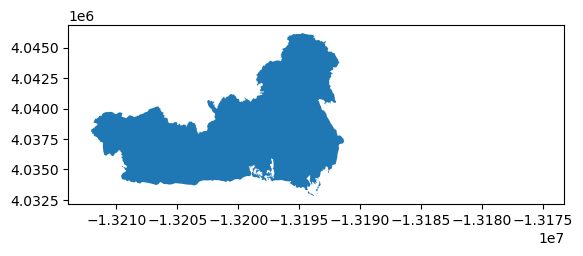

In [5]:
palisades_boundary.plot()

In [8]:
fire_perimeters_dissolved = pd.concat([palisades_boundary, fire_perimeters])

In [ ]:
# Obtain the geographic extent of the geo-dataframe
fire_perimeters.total_bounds

In [ ]:
# Create function that checks the geometry types of the of the dataframe
def check_polygons(gdf):
    geometry_types = gdf.geometry.geom_type.unique()
    
    if len(geometry_types) == 1:
        print(f"All features are: {geometry_types[0]}")
    else:
        print(f"Multiple feature types: {', '.join(geometry_types)}")

#### Summary of Preliminary Data Exploration for Fire Perimeters GeoDataFrame
The `fire_perimeters` dataset is a  `geopandas.geodataframe`. The geodataframe has one feature type (Polygon and Multipolygon). It has a projected CRS of EPSG:3857. The units of the coordinates are in meters. The data types of each column are: string (object), integer (int64), floating decimal numbers (float64) for the acreage of  each fire perimeter, and geometry. The dimensions of the geodataframe are 2 rows and 15 columns. The total bounds of the geodataframe are -13212082.926963, 4032949.88145929, -13137160.9453166, 4060781.94401591. 

### 3. NetCDF data import and exploration

In [10]:
# Read in Landsat 8 data
landsat8 = xr.open_dataset('data/landsat8-2025-02-23-palisades-eaton.nc')

In [ ]:
# Check the x-axis of the array
landsat8.x

In [ ]:
# Check the y-axis of the array
landsat8.y

In [ ]:
# View the variables of the dataset
landsat8.variables

In [19]:
# View a summary of information about `landsat8`
landsat8.info

<bound method Dataset.info of <xarray.Dataset> Size: 78MB
Dimensions:      (y: 1418, x: 2742)
Coordinates:
  * y            (y) float64 11kB 3.799e+06 3.799e+06 ... 3.757e+06 3.757e+06
  * x            (x) float64 22kB 3.344e+05 3.344e+05 ... 4.166e+05 4.166e+05
    time         datetime64[ns] 8B ...
    spatial_ref  int32 4B 0
Data variables:
    red          (y, x) float32 16MB ...
    green        (y, x) float32 16MB ...
    blue         (y, x) float32 16MB ...
    nir08        (y, x) float32 16MB ...
    swir22       (y, x) float32 16MB ...>

In [ ]:
# Check the class of the dataset
landsat8.__class__

In [20]:
# Check the contents of the dataset
landsat8.__contains__

<bound method Dataset.__contains__ of <xarray.Dataset> Size: 78MB
Dimensions:      (y: 1418, x: 2742)
Coordinates:
  * y            (y) float64 11kB 3.799e+06 3.799e+06 ... 3.757e+06 3.757e+06
  * x            (x) float64 22kB 3.344e+05 3.344e+05 ... 4.166e+05 4.166e+05
    time         datetime64[ns] 8B ...
    spatial_ref  int32 4B 0
Data variables:
    red          (y, x) float32 16MB ...
    green        (y, x) float32 16MB ...
    blue         (y, x) float32 16MB ...
    nir08        (y, x) float32 16MB ...
    swir22       (y, x) float32 16MB ...>

In [21]:
# Check the data types of the variables within `landsat8`
landsat8.dtypes

Frozen({'red': dtype('float32'), 'green': dtype('float32'), 'blue': dtype('float32'), 'nir08': dtype('float32'), 'swir22': dtype('float32')})

In [22]:
# Check the dimensions of the dataset
landsat8.dims

FrozenMappingWarningOnValuesAccess({'y': 1418, 'x': 2742})

In [23]:
# View the number of missing values within the dataset
landsat8.isnull().sum()

<xarray.Dataset> Size: 32B
Dimensions:      ()
Coordinates:
    time         datetime64[ns] 8B ...
    spatial_ref  int32 4B 0
Data variables:
    red          int32 4B 0
    green        int32 4B 1
    blue         int32 4B 109
    nir08        int32 4B 0
    swir22       int32 4B 0

#### Summary of Preliminary Exploration for `landsat8`
> The blue band variable has 109 missing values while the green band has only one missing variable. The rest of the variables don't have missing values. The dimensions of the data set are 1418 'y-coordinates and 2742 x-coordinates. The data types of the bands are integers while the time variable is in datetime format. The units of measurement for the variables are in meter. The CRS is EPSG:32611. 

### 4. Restoring Geospatial Information


In [ ]:
# Print the CRS of `landsat8`
print(landsat8.rio.crs)

In [24]:
# Print the CRS by using accesing the spatial_ref.crs_wkt attribute of the dataset
landsat8.spatial_ref.crs_wkt

'PROJCS["WGS 84 / UTM zone 11N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-117],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32611"]]'

In [11]:
# Recover the geospatial information and the spatial reference information 
landsat8.rio.write_crs('EPSG:32611', inplace=True)

# Print the CRS of the updated dataset
print(landsat8.rio.crs)

EPSG:32611


In [25]:
landsat8.data_vars

Data variables:
    red      (y, x) float32 16MB 1.024e+04 9.886e+03 ... 1.019e+04 9.967e+03
    green    (y, x) float32 16MB 9.93e+03 9.687e+03 ... 9.984e+03 9.662e+03
    blue     (y, x) float32 16MB 9.29e+03 9.183e+03 ... 9.49e+03 9.187e+03
    nir08    (y, x) float32 16MB 1.331e+04 1.313e+04 ... 1.287e+04 1.306e+04
    swir22   (y, x) float32 16MB 1.43e+04 1.437e+04 ... 1.406e+04 1.329e+04

### 5. True Color Image

In [ ]:
# Select the red, green, and blue variables 
landsat8[['red', 'green', 'blue']].to_array().plot.imshow()

In [ ]:
# Adjust the scale used for plotting the bands to get a true color image by setting the robust parameter to True
landsat8[['red', 'green', 'blue']].to_array().plot.imshow(robust=True)

In [ ]:
# Identify which bands have missing values
landsat8.isnull().sum()

In [12]:
# Substitute any missing values in the dataset with zeroes
landsat8_filled = landsat8.fillna(0)

In [ ]:
# Create a true color image without warnings
landsat8_filled[['red','green','blue']].to_array().plot.imshow(robust=True)

#### True Color Image Generation Summary
The output for our first true color image was a blank plot with two warnings. Because clouds are extremely bright, they stretch the scale, so the non-cloud pixels are squeezed into a tiny part of the range. As a result, the entire image looks blank. After setting the `robust` parameter to True, this tells xarray to ignore the extreme outliers. This fixed the first warning. The second warning mentioned invalid values, likely due to the presence of nan values. To identify which bands contain missing values, I used `landsat8.isnull().sum()`, which counts the number of missing pixels in each data variable. This revealed that the green and blue bands included NaN values and allowed us to understand why the warning occurred. To remove the NaN-related plotting warning, I applied fillna(0) to the dataset and then generated the true color image using the filled data. This ensured that the image plotted without warnings.

### 6. False Color Image

In [ ]:
# Create a false color image
landsat8_filled[['swir22', 'nir08', 'red']].to_array().plot.imshow(robust=True)

### 7. Map 

In [13]:
# Reproject the fire_perimeters polygons to the landsat dataset
fire_perimeters_dissolved = fire_perimeters_dissolved.to_crs(landsat8_filled.rio.crs)

In [15]:
# Verify that both datasets have the same CRS
assert landsat8_filled.rio.crs == fire_perimeters_dissolved.crs

In [29]:
landsat8_filled.rio.bounds()

(334395.0, 3756525.0, 416655.0, 3799065.0)

In [ ]:
# Create bounding box for fire perimeters
bbox = box(334395.0, 3756525.0, 416655.0, 3799065.0)
fires_bbox = gpd.GeoDataFrame(geometry = [bbox])
fires_bbox

In [41]:
?gpd.clip

Signature: gpd.clip(gdf, mask, keep_geom_type=False)
Docstring:
Clip points, lines, or polygon geometries to the mask extent.

Both layers must be in the same Coordinate Reference System (CRS).
The ``gdf`` will be clipped to the full extent of the clip object.

If there are multiple polygons in mask, data from ``gdf`` will be
clipped to the total boundary of all polygons in mask.

If the ``mask`` is list-like with four elements ``(minx, miny, maxx, maxy)``, a
faster rectangle clipping algorithm will be used. Note that this can lead to
slightly different results in edge cases, e.g. if a line would be reduced to a
point, this point might not be returned.
The geometry is clipped in a fast but possibly dirty way. The output is not
guaranteed to be valid. No exceptions will be raised for topological errors.

Parameters
----------
gdf : GeoDataFrame or GeoSeries
    Vector layer (point, line, polygon) to be clipped to mask.
mask : GeoDataFrame, GeoSeries, (Multi)Polygon, list-like
    Polygo

In [42]:
fires_clipped = gpd.clip(fire_perimeters_dissolved, (334395.0, 3756525.0, 416655.0, 3799065.0))

In [ ]:
fires_clipped[(fires_clipped['mission'] == 'CA-LFD-PALISADES-N40Y') & (fires_clipped['incident_n'] == ['Palisades', 'Eaton'])]

ValueError: ('Lengths must match to compare', (28,), (2,))

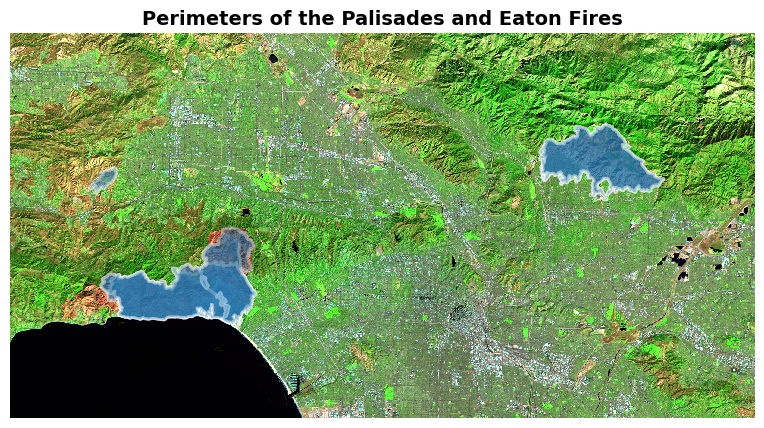

In [49]:
fig, ax = plt.subplots(figsize=(11,5))
ax.axis('off')

landsat8_filled[['swir22', 'nir08', 'red']].to_array().plot.imshow(robust=True, ax = ax)
fires_clipped.plot(ax = ax,
                     color= None,
                     alpha = 0.2,
                     edgecolor= 'white',
                     linewidth=2)

ax.set_title("Perimeters of the Palisades and Eaton Fires", fontsize=14, fontweight='bold')

plt.show()